# PolynomialCompressor class

- Off-the-shelf compressors for refrigeration machines or heat pumps
- Use datasheet to compute polynomials for isentropic and volumetric efficiency
  as function of evaporation and condensation temperature (DIN EN12900)

## Example data workflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tespy.components.turbomachinery.polynomial_compressor import fit_EN12900, generate_eta_polys_from_data, generate_eta_polys_from_power_and_cooling_polys, calc_EN12900

In [2]:
# 50 Hz
power = pd.DataFrame(columns=[10,7.5,5,0,-5,-10], index=[30, 40, 50], dtype=float)
cooling = power.copy()

cooling.loc[30] = [465600,424100,385500,316700,257900,208000]
cooling.loc[40] = [418900,380400,344800,281400,227400,181600]
cooling.loc[50] = [365900,331300,299200,242100,193700,152900]

power.loc[30] = [62.0,61.8,61.8,61.8,61.7,61.3]
power.loc[40] = [78.0,78.0,78.0,78.0,77.7,76.8]
power.loc[50] = [99.2,99.2,99.2,98.9,98.1,96.5]

# we want everything in W
power = power * 1000

In [3]:
generate_eta_polys_from_data(
    power, cooling, "R134a",
    reference_state={"T_sh": 10, "T_sc": 0, "rpm_poly": 50 * 60, "rpm_displacement": 20 * 60, "displacement": 214}
)

(array([ 3.43412278e-03, -3.75380537e-02,  4.38171871e-02, -9.22215138e-04,
         1.68048644e-03, -8.88186944e-04, -7.56880279e-06,  1.60832259e-05,
        -1.52699352e-05,  4.96863559e-06]),
 array([ 5.81013643e-03, -7.80317410e-04,  7.41237123e-02,  2.76836447e-05,
         6.18407793e-05, -1.88935402e-03,  7.89233342e-07, -1.94914508e-06,
         5.08103608e-07,  1.50773205e-05]))

# Workflow

- Berechnung der Polynome bei unterschiedlichen Drehzahlen
- Dem Kompressor die unterschiedlichen Polynome vorgeben
- Bei vorgegebener Drehzahl: Interpolieren der Polynomkoeffizienten im preprocessing
- Bei nicht vorgegebener Drehzahl: Interpolieren in den Iterationen

- Vorgehensweise: Vorgabe der polynome pro RPM
- PolynomialCompressorWithRPMInterpolation
- Idee: Auslegungssoftware Bitzer nutzen und displacement bei unterschiedlichen RPM testen

In [4]:
# variant 1
eta_s_poly, eta_vol_poly = generate_eta_polys_from_data(
    power, cooling, "R134a",
    reference_state={"T_sh": 10, "T_sc": 0, "rpm_poly": 50 * 60, "rpm_displacement": 20 * 60, "displacement": 214}
)

# variant 2
power_poly = fit_EN12900(power.columns, power.index, power.values)
cooling_poly = fit_EN12900(cooling.columns, cooling.index, cooling.values)
eta_s_poly2, eta_vol_poly2 = generate_eta_polys_from_power_and_cooling_polys(
    power_poly, cooling_poly,
    t_evap=power.columns, t_cond=power.index,
    fluid="R134a",
    reference_state={"T_sh": 10, "T_sc": 0, "rpm_poly": 50 * 60, "rpm_displacement": 20 * 60, "displacement": 214}
)
assert (eta_s_poly == eta_s_poly2).all()
assert (eta_vol_poly == eta_vol_poly2).all()

In [5]:
T_cond = np.linspace(30, 50)
T_evap = np.linspace(-10, 10)
T_evap, T_cond = np.meshgrid(T_evap, T_cond)

eta_s = calc_EN12900(eta_s_poly, T_evap, T_cond)
eta_vol = calc_EN12900(eta_vol_poly, T_evap, T_cond)

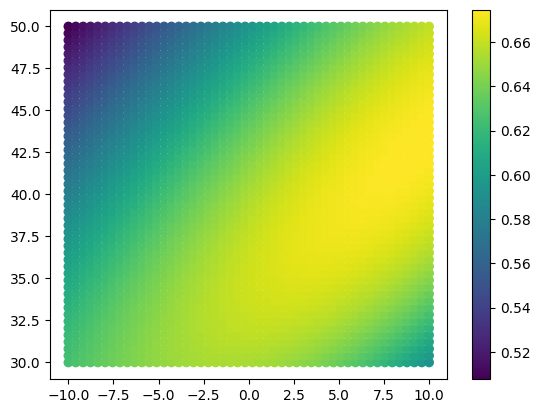

In [6]:
fig, ax = plt.subplots()

im = ax.scatter(
    x=T_evap,
    y=T_cond,
    c=eta_s
)
plt.colorbar(im)

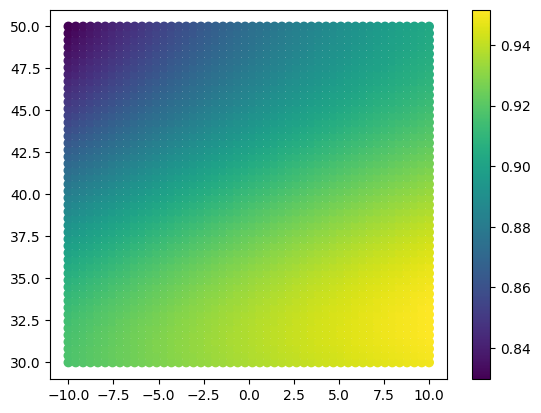

In [7]:
fig, ax = plt.subplots()

im = ax.scatter(
    x=T_evap,
    y=T_cond,
    c=eta_vol
)
plt.colorbar(im)

## Application tespy model

In [8]:
from tespy.components import Source, Sink, PolynomialCompressor, PowerSource
from tespy.networks import Network
from tespy.connections import Connection, PowerConnection

In [9]:
nw = Network()
nw.units.set_defaults(
    temperature="degC",
    pressure="bar"
)


so = Source("source")
si = Sink("sink")
grid = PowerSource("grid")
compressor = PolynomialCompressor("compressor")

c1 = Connection(so, "out1", compressor, "in1")
c2 = Connection(compressor, "out1", si, "in1")

e1 = PowerConnection(grid, "power", compressor, "power", label="e1")

nw.add_conns(c1, c2, e1)

In [10]:
c1.set_attr(fluid={"R134a": 1}, td_dew=10, T_dew=-5)
c2.set_attr(T_bubble=50)

In [11]:
reference_state={"T_sh": 10, "T_sc": 0, "rpm_poly": 50 * 60, "rpm_displacement": 20 * 60, "displacement": 214}
compressor.set_attr(
    dissipation_ratio=0.1, eta_s_poly=eta_s_poly, eta_vol_poly=eta_vol_poly, reference_state=reference_state, rpm=3000
)

In [12]:
nw.solve("design")
compressor.Q_diss.val


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.17e+06   | 0 %        | 2.31e-01   | 0.00e+00   | 5.35e+05   | 0.00e+00   | 3.92e+04   
 2     | 1.38e+05   | 9 %        | 2.55e-14   | 0.00e+00   | 8.15e-03   | 0.00e+00   | 1.38e+05   
 3     | 6.53e-03   | 90 %       | 0.00e+00   | 0.00e+00   | 8.31e-11   | 0.00e+00   | 6.53e-03   
 4     | 2.19e-10   | 100 %      | 0.00e+00   | 0.00e+00   | 2.38e-11   | 0.00e+00   | 1.80e-10   
 5     | 6.00e-11   | 100 %      | 0.00e+00   | 0.00e+00   | 2.38e-11   | 0.00e+00   | 1.97e-11   
Total iterations: 5, Calculation time: 0.01 s, Iterations per second: 921.70


-9830.84546806816

In [13]:
import itertools


power_from_tespy = power.copy() * np.nan  # copy power df and set all to nan to not by accident keep old values
outlet_state = power.copy() * np.nan  # copy power df and set all to nan to not by accident keep old values
nw.set_attr(iterinfo=False)

for t_evap, t_cond in itertools.product(power.columns, power.index):

    c1.set_attr(fluid={"R134a": 1}, T_dew=t_evap)
    c2.set_attr(T_bubble=t_cond)
    nw.solve("design")
    power_from_tespy.loc[t_cond, t_evap] = compressor.P.val
    outlet_state.loc[t_cond, t_evap] = c2.T.val


(power_from_tespy - power) / power * 100  # % deviation

,10.0,7.5,5.0,0.0,-5.0,-10.0
30,-0.229605,0.124473,0.127544,0.049647,-0.051229,-0.033595
40,0.163739,0.011592,-0.077284,-0.192965,-0.093244,0.203047
50,0.003840,-0.053774,-0.070377,0.107117,0.212492,-0.204725


In [14]:
outlet_state

,10.0,7.5,5.0,0.0,-5.0,-10.0
30,48.841028,49.144063,49.626005,51.241626,53.943817,58.025999
40,58.900507,59.676947,60.712218,63.700583,68.176985,74.457680
50,71.438609,72.948160,74.814287,79.782645,86.647262,95.524375


In [15]:
compressor.set_attr(
    dissipation_ratio=0.0
)

for t_evap, t_cond in itertools.product(power.columns, power.index):

    c1.set_attr(T_dew=t_evap)
    c2.set_attr(T_bubble=t_cond)
    nw.solve("design")
    outlet_state.loc[t_cond, t_evap] = c2.T.val

outlet_state

,10.0,7.5,5.0,0.0,-5.0,-10.0
30,51.106537,51.611695,52.317701,54.460050,57.817260,62.712627
40,61.674726,62.701640,64.019202,67.683189,73.010578,80.346099
50,74.918014,76.760975,79.004469,84.876177,92.862844,103.078722
